# ResNet Regression --> x --> ResNet Classification  y

# ALL libraries

In [14]:
#other libs :
import numpy as np
import matplotlib.pyplot as plt

#my libs :
from functions import *

# for dataset manipulation : 
import pickle    #to load and save files
from sklearn.model_selection import train_test_split  #splitting the dataset
#from google.colab import files #enable to download files from google colab on the drive

#Keras libs :
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import os

# FOR TENSORBOARD :
from keras.callbacks import TensorBoard

#To adjust optimizers
from keras import optimizers

### -------------------- Allow dynamic memory growth
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

SyntaxError: import * only allowed at module level (<ipython-input-14-61af1aecac84>, line 2)

# ------------------------------------------------------------------------------------------
# 1) SETTING THE PARAMETERS -----------------------------------------------------
# ------------------------------------------------------------------------------------------

In [15]:
# --------- parameters ---------- °

pic_size = 128 #to change after
nb_channel = 1 #greyscale
Vmax = 16 #maximum value of the all dataset
K = int(Vmax//(2*np.pi)) + 1 #the number of classes, for each pixel, we will either have to add {0, 1, ..., K} * 2pi !
my_test_size = 0.2 #the ratio of data used for the validation

# ------------------------------------------------------------------------------------------
# 2) LOADING DATASET + Completing it +  Putting it on the right format ---------
# ------------------------------------------------------------------------------------------

## 2.1 a) Loading Dataset From IMAGE.NET

In [0]:
#Y = pickle.load( open( "dataset_6cases_0to2000_Vmax16_v1.pkl", "rb" ) )

## 2.1 b) Loading Dataset From Custom Made Dataset

In [0]:
#Y = pickle.load( open ("dataset_without_data_augmentation_v2.pkl", "rb") )
#Y = np.load('dataset_without_data_augmentation_v1.npy')

## 2.1 c) Load an already split dataset
Order : First Y_train, Then Y_valid

In [16]:
path = '../DATASET/dataset/dataset_6cases_0to2000_Vmax16_V2_Struct2_Kernel5_Adam/'
Y = pickle.load( open( path + "Ytv_dataset_6cases_0to2000_Vmax16_v2", "rb" ) )
#Y = pickle.load( open( "Ytv_dataset_Own1_0to100_Vmax16_v1", "rb" ) )

## 2.2 Checking the Characteristics of the loaded dataset + Setting parameter nb_picture

In [17]:
print("Y.shape =", Y.shape)
print("Vmax = ", np.amax(Y[:,:,:,0]))
nb_picture = Y.shape[0] #the nb of pictures in the dataset

Y.shape = (12000, 128, 128, 1)
Vmax =  16.0


## 2.3 As the dataset contains only the Ground Truth Pictures, here we create the wrapped pictures, plus the labelling Yk

### 2.3.1 Creation of the Wrapped Pictures

In [18]:
# ------------------ CREATING THE WRAPPED PICTURE ---- X
X = np.zeros( Y.shape )

for i in np.arange(nb_picture):
  X[i] = modulo(Y[i])

### 2.3.2 Creation of the Yk labels

In [19]:
Y_K = np.full( (*Y.shape[0:3], K) , False) #Same as np.zeros( (*Y.shape[0:3], K) , dtype=bool)
print(" Y_K.shape = ", Y_K.shape )

Y_K = make_label(Y, X, Y_K)

 Y_K.shape =  (12000, 128, 128, 3)


## 2.4 Checking the dataset

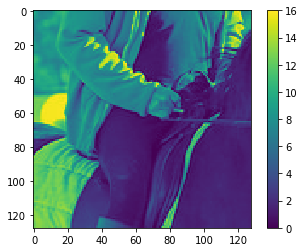

In [20]:
plt.imshow(Y[1*20+4,:,:,0])
plt.colorbar()

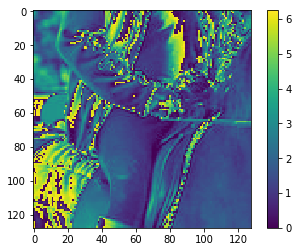

In [21]:
plt.imshow(X[1*20+4,:,:,0])
plt.colorbar()

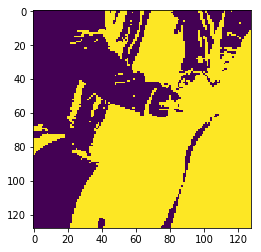

In [23]:
plt.imshow(Y_K[1*20+4,:,:,0])

# ------------------------------------------------------------------------------------------
#3.  Splitting the dataset --> X_train, Y_train, Y_K_train, X_valid, Y_valid, Y_K_valid
# ------------------------------------------------------------------------------------------
So in this model we have 2 outputs : Y the ground truth picture, Y_K the labelling picture

## 3.1 a) Splitting the dataset

In [24]:
# TO SPLIT DATA SET
X_train, X_valid, Y_train, Y_valid, Y_K_train, Y_K_valid = train_test_split(X, Y, Y_K, test_size= my_test_size, shuffle= True)

In [0]:
# Check the size
print(" X_train.shape = {} \n X_valid.shape = {} \n Y_train.shape = {} \n Y_valid.shape = {} \n Y_K_train.shape = {} \n Y_K_valid.shape = {} ".format(
        X_train.shape,  X_valid.shape, Y_train.shape, Y_valid.shape, Y_K_train.shape, Y_K_valid.shape) )

 X_train.shape = (9600, 128, 128, 1) 
 X_valid.shape = (2400, 128, 128, 1) 
 Y_train.shape = (9600, 128, 128, 1) 
 Y_valid.shape = (2400, 128, 128, 1) 
 Y_K_train.shape = (9600, 128, 128, 3) 
 Y_K_valid.shape = (2400, 128, 128, 3) 


## 3.1 a) And maybe save the splitting (and download it)

In [0]:
# ----------------   Saving the splitting   ------------------------
the_name = "Ytv_dataset_Own1_0to100_Vmax16_v1"


Ytv = np.array(Y_train)
Ytv = np.concatenate((Ytv, Y_valid), axis = 0)
print(" Ytv.shape = ", Ytv.shape)


# write to Pickle
pickle.dump( Ytv , open( the_name , "wb" ) )

In [0]:
# ------------------- Downlaod the splitting on the Desktop -------------
from google.colab import files
files.download(the_name) 

## 3.1 b) Recover (load) a split dataset

In [25]:
# Recover the data with the same split -----------------------
idx_split = int(nb_picture*(1-my_test_size))
train_size = (idx_split, pic_size, pic_size, 1)
valid_size = (nb_picture - idx_split, pic_size, pic_size, 1)

#create the train and validation variables
X_train = np.zeros( train_size )
X_valid = np.zeros( valid_size  )
Y_train = np.zeros( train_size )
Y_valid = np.zeros( valid_size )
Y_K_train = np.zeros( (idx_split, pic_size, pic_size, 3) )
Y_K_valid = np.zeros( (nb_picture - idx_split, pic_size, pic_size, 3) )

#set the train and validation variables
Y_train = Y[0:idx_split,:,:,:]
Y_valid = Y[idx_split:nb_picture,:,:,:]
X_train = X[0:idx_split,:,:,:]
X_valid = X[idx_split:nb_picture,:,:,:]
Y_K_train = Y_K[0:idx_split,:,:,:]
Y_K_valid = Y_K[idx_split:nb_picture,:,:,:]

In [35]:
#making memory space -----
del Y
del X
del Y_K

In [26]:
# Check the size
print(" X_train.shape = {} \n X_valid.shape = {} \n Y_train.shape = {} \n Y_valid.shape = {} \n Y_K_train.shape = {} \n Y_K_valid.shape = {} ".format(
        X_train.shape,  X_valid.shape, Y_train.shape, Y_valid.shape, Y_K_train.shape, Y_K_valid.shape) )

 X_train.shape = (9600, 128, 128, 1) 
 X_valid.shape = (2400, 128, 128, 1) 
 Y_train.shape = (9600, 128, 128, 1) 
 Y_valid.shape = (2400, 128, 128, 1) 
 Y_K_train.shape = (9600, 128, 128, 3) 
 Y_K_valid.shape = (2400, 128, 128, 3) 




## 3.2 Check the splitting



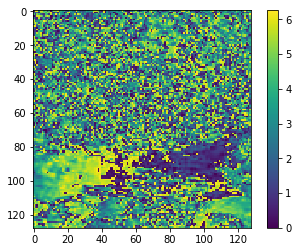

In [27]:
#check the split
#Y_train.shape
plt.imshow(X_train[4,:,:,0])
plt.colorbar()

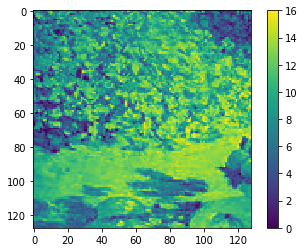

In [28]:
plt.imshow(Y_train[4,:,:,0])
plt.colorbar()


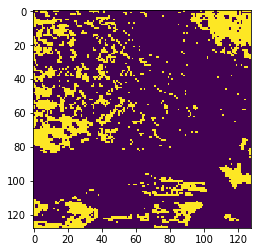

In [29]:
plt.imshow(Y_K_train[4,:,:,0])

# ------------------------------------------------------------------------------------------
# 4. Creating the Model
# ------------------------------------------------------------------------------------------

In [30]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,                
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation function (relu, sigmoid, etc.)
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    #2 possibilities : 
    # 1) First convolute, then normalize
    # 2) First normalize, then convolute
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [31]:
def residual_block(inputs, nb_filters_out = 32 , activation = 'relu', batch_normalization = 'true', kernel_size = 5):
    """Residual_block

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers

    # Returns
        model (Model): Keras model instance
    """
    
    #Need to remove this from here later
    strides = 1
    kernel_size_res = 1
    
    # x = residual of the block
    x = resnet_layer(inputs=inputs,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size_res,
                     strides=strides,
                     activation=None,
                     batch_normalization=batch_normalization,
                     conv_first=False)
    
    # y = picture we transform in the block
    y = resnet_layer(inputs=inputs,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=activation,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    y = resnet_layer(inputs=y,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=activation,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    y = resnet_layer(inputs=y,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=None,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    
    x = keras.layers.add([x, y])
    x = resnet_layer(inputs = x,          
                    num_filters = nb_filters_out, #For now, the whole block will end up with nb_filters_out filters
                    kernel_size = kernel_size,
                    strides = strides,
                    activation = activation, #Before : None
                    batch_normalization = False)

    return x 
    
    #Instatiate model : 
    #model = Model(inputs=inputs, outputs=x)
    #return model


In [32]:
def complete_resnet_resnet(input_shape, depth):
    """Residual_block

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers

    # Returns
        model (Model): Keras model instance
        
    Stucture :
    
    inputs --> RESNET (regression) --> x --> RESNET (classification) --> y
    outputs = [x,y]
        
    """
    
    activation = 'relu'
    batch_normalization = True
    strides = 1
    my_kernel_size = 5                      # I CHANGED TO 5
    
   
    #filters = [16, 24, 24, 32, 32, 24, 24, 16, 1]  #As in the papers
    filters = [24, 32, 32, 32, 32, 32, 32, 24, 1] #a test ----- struct2
    #filters = [16, 16, 24, 24, 24, 24, 32, 32, 24, 24, 16, 16, 1] #Try1
    
    # inputs = original picture entry
    x = inputs = Input(shape=input_shape)
    
    # -------------- RESNET (regression) --------------------
    #apply a sequence of residual networks 
    for fil in filters:
      x = residual_block(x, nb_filters_out = fil, kernel_size= my_kernel_size)
      
    # -------------- RESNET (classification )-----------------
    filters_K = filters #same as the first prediction part
    y = x #we keep the output of the first ResNet into x
    
    for fil in filters_K:
      y = residual_block(y, nb_filters_out = fil, kernel_size= my_kernel_size)
    y = Dense(K, activation='softmax', kernel_initializer='he_normal')(y) #K = nb_class
    
    #Instantiate the model
    model = Model(inputs=inputs, outputs=[x,y])
    return model

In [0]:
def lr_schedule(epoch, factor = 3):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs
        factor (int): how quickly the lr decreases

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > factor*15:
        lr *= 1e-5
    elif epoch > factor*13:
        lr *= 1e-4
    elif epoch > factor*10:
        lr *= 1e-4
    elif epoch > factor*8:
        lr *= 1e-3
    elif epoch > factor*5:
        lr *= 1e-2
    elif epoch > factor*3:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [33]:
#----------------------------------------------------------------------------
#To adjust learning rate : 
#lr_scheduler = LearningRateScheduler(lr_schedule)
#callbacks = [lr_scheduler]


#double output with ResNet ResNet
model = complete_resnet_resnet( (pic_size, pic_size, 1), 56)

losses = ['mean_squared_error', 'categorical_crossentropy']
lossWeights = [1.0, 1.0] #------ TO adjust !! 
                         

#-------------------------------------------------------------------------------
# to adjust learning rate :
#model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mse'], )
model.compile(optimizer='Adam', loss=losses, loss_weights=lossWeights, metrics=['mse'], )

# FIXED lr
#sgd = optimizers.SGD(lr=1e-7, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mean_squared_error', optimizer=sgd)


#Without lr
#model.compile(optimizer='Adam', loss="mean_squared_error", metrics=['mse'], ) 

Instructions for updating:
Colocations handled automatically by placer.


# Some tests : 

nb_epoch = 100

- T1 : double output : ResNet (regression) + ResNet (classification)
  - filters = struct2
  - kernel_size = 5
  
  

# ------------------------------------------------------------------------------------------
# 5. Learning
# ------------------------------------------------------------------------------------------

## 5.1) Maybe load a model to continue a learning

In [0]:
# --------- to load model : ----------
#filepath = "model_dataset_6cases_0to2000_Vmax12_struct1_epoch100_lrAdam_v1"
#filepath = "model_6cases_0to2000_Vmax16_epoch100_v2_fullAdam"

#model = keras.models.load_model(filepath)

In [37]:
X_train[0:10].shape

(10, 128, 128, 1)

## 5.2) Learning

In [39]:
nb_epoch = 1
batch_size = 1             #try several things #ADJUST ----------------

#------------------------------------------------------------------------------
#set tensorboard callback
#tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
#                         write_graph=True,
#                         write_grads=False, #Before : True
#                         batch_size=batch_size,
#                         write_images=True)
#tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))


model.fit(X_train[0:10], [Y_train[0:10], Y_K_train[0:10]], validation_data=(X_valid[0:10], [Y_valid[0:10], Y_K_valid[0:10]]), epochs=nb_epoch, callbacks=[] )
#model.fit(X_train, Y_train, validation_data=(X_test, y_test), epochs=3)

#print(model.history)

#initial loss : 28
#initial loss_val : 

Train on 10 samples, validate on 10 samples
Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[10,32,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node batch_normalization_54/FusedBatchNorm}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/dense_1_loss/Mean_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


# ------------------------------------------------------------------------------------------
# 6. Analyse the results
# ------------------------------------------------------------------------------------------

In [0]:
idx = 8 #idx we want to check

shape =  (128, 128, 1)


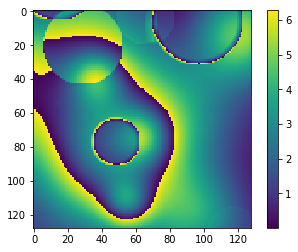

In [0]:
print("shape = ", X[idx].shape)
plt.imshow(X[idx,:,:,0])
plt.colorbar()

In [0]:
[y_pred, y_k_pred] = model.predict(X)
print("y_k_pred.shape = ", y_k_pred.shape)
print("y_k_pred type  = ", type(y_k_pred[idx,0,0,0]))

y_k_pred.shape =  (100, 128, 128, 3)
y_k_pred type  =  <class 'numpy.float32'>


max_value =  15.7320795


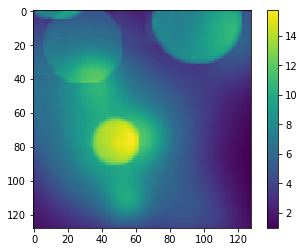

In [0]:
# =============== PREDICTION : REGRESSION

plt.imshow(y_pred[idx,:,:,0])
plt.colorbar()
print("max_value = ", np.amax(y_pred[idx,:,:,0]))

type =  <class 'numpy.bool_'>
min_val =  False
max_val =  True


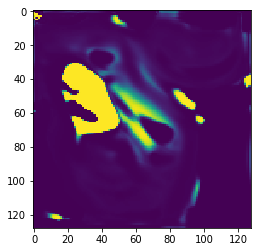

In [0]:
the_class = 0

Y_K_pred = np.full( (*y_k_pred.shape[0:3], K) , False)
Y_K_pred = y_k_pred.astype(bool)

# =============== PREDICTION : CLASSIFICATION
plt.imshow(y_k_pred[idx,:,:,the_class])
#plt.imshow(Y_K_pred[idx,:,:,the_class])
#plt.colorbar()
print("type = ", type(Y_K_pred[idx,0,0,the_class]))
print("min_val = ", np.amin(Y_K_pred[idx,:,:,the_class]))
print("max_val = ", np.amax(Y_K_pred[idx,:,:,the_class]))

max_value =  16.0


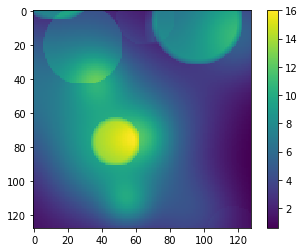

In [0]:
plt.imshow(Y[idx,:,:,0])
plt.colorbar()
print("max_value = ", np.amax(Y[idx,:,:,0]))

## 6.2) RSNR function

In [0]:
def rsnr(rec,oracle): #How does this actually work ???
  """
  calculate rsnr between picture rec and oracle in [dB]
  - oracle : restored image
  - rec : input image (I guess ???)
  """
  sumP = sum(oracle.reshape(-1))
  sumI = sum(rec.reshape(-1))
  sumIP = sum( oracle.reshape(-1) * rec.reshape(-1) )
  sumI2 = sum(rec.reshape(-1)**2)
  A = np.matrix([[sumI2, sumI],[sumI, oracle.size]])
  b = np.matrix([[sumIP],[sumP]])
  c = np.linalg.inv(A)*b
  rec = c[0,0]*rec+c[1,0] #linear regression : mean of the restored image
  err = sum((oracle.reshape(-1)-rec.reshape(-1))**2)
  SNR = 10.0*np.log10(sum(oracle.reshape(-1)**2)/err)
  return SNR 
 

In [0]:
idx = 10
pic_pred = X_train[idx,:,:,0] #I don't have the model now so I put the input (instead of the actual prediction)
pic_gt = Y_train[idx,:,:,0] #gt = ground truth

pic_pred_test = pic_gt[:,:]-1

print("size = ", pic_pred_test.shape)
rSNR = rsnr(pic_pred_test,  pic_gt)
print(rSNR)

#the higher, the better !

size =  (128, 128)
281.58311272626514


## 6.3) Reconstruct picture from labels

pic_k.shape =  (128, 128, 3)
grid shape =  (3,)
grid =  [0 1 2]
out shape =  (128, 128)
final_out.shape =  (128, 128)


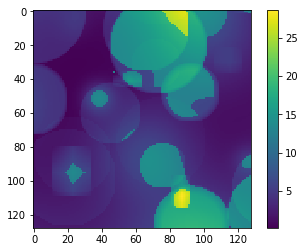

In [0]:
idx = 8

the_pic = Y_train[idx,:,:,0]
pic_k = Y_K_train[idx,:,:,:]
print("pic_k.shape = ", pic_k.shape)

grid = np.array(np.arange(K))
print("grid shape = ", grid.shape)
print("grid = ", grid)

out = np.dot(pic_k,grid)
print("out shape = ", out.shape)

cst = np.pi*2
final_out = the_pic + cst*out
print("final_out.shape = ", final_out.shape)

plt.imshow( final_out[:,:] )
plt.colorbar()

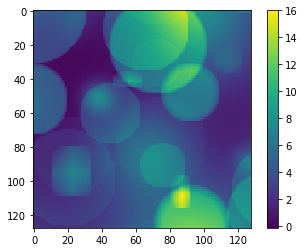

In [0]:
plt.imshow( the_pic )
plt.colorbar()

# ------------------------------------------------------------------------------------------
# 7. Save And Load Model
# ------------------------------------------------------------------------------------------

In [0]:
# TO SAVE MODEL
#filepath = "model_6cases_0to2000_Vmax16_epoch100_v2"
filepath = "model_dataset_6cases_0to2000_Vmax16_epoch5_Adam_resnet_regression_resnet_classification"
model.save(filepath)

from google.colab import files
files.download(filepath) 

In [0]:
#to load model : 
filepath = "model_v1"
model = keras.models.load_model(filepath)

OSError: ignored

#Tensorboard to analyse the training :

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

#MODEL TRAINED OF PICTURE WITH EASY DATASET £

In [0]:
Y_easy = pickle.load( open( "dataset_without_data_augmentation_v2.pkl", "rb" ) )


In [0]:
# ------------------ CREATING THE WRAPPED PICTURE ---- X

#Y = np.ndarray( (nb_picture, pic_size, pic_size, nb_channel) 
X_easy = np.zeros( Y_easy.shape )

for i in np.arange( Y_easy.shape[0]):
  X_easy[i] = modulo(Y_easy[i])

shape =  (128, 128, 1)


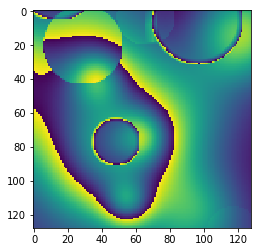

In [0]:
print("shape = ", X_easy[0].shape)
plt.imshow(X_easy[8,:,:,0])

In [0]:
y_easy_pred = model.predict(X_easy)

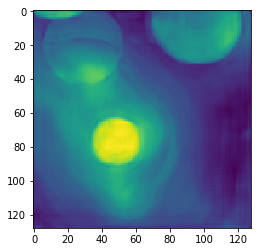

In [0]:
plt.imshow(y_easy_pred[8,:,:,0])

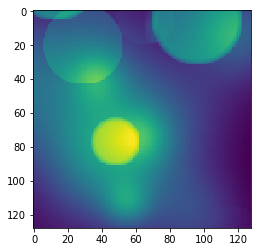

In [0]:
plt.imshow(Y_easy[8,:,:,0])

In [ ]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

#import zipfile

#!unzip "dataset_6cases_0to2000_Vmax16_v1.zip"

#!unzip "dataset_6cases_0to2000_Vmax12_v1"
!unzip "Ytv_dataset_6cases_0to2000_Vmax16_v2.zip"

#To get tensorboard on google collab

#just the first time : 
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

#ALL libraries

#other libs :
import numpy as np
import matplotlib.pyplot as plt

#my libs :
from functions import *

# for dataset manipulation : 
import pickle    #to load and save files
from sklearn.model_selection import train_test_split  #splitting the dataset
from google.colab import files #enable to download files from google colab on the drive

### -------------------- Allow dynamic memory growth
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

#resnet libs :
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import os

# FOR TENSORBOARD :
from keras.callbacks import TensorBoard

#To adjust optimizers
from keras import optimizers

#to import files (probably not needed)
#dfrom google.colab import files
#files.upload()

# ------------------------------------------------------------------------------------------
# 1) SETTING THE PARAMETERS -----------------------------------------------------
# ------------------------------------------------------------------------------------------

# --------- parameters ---------- °

pic_size = 128 #to change after
nb_channel = 1 #greyscale
Vmax = 16 #maximum value of the all dataset
K = int(Vmax//(2*np.pi)) + 1 #the number of classes, for each pixel, we will either have to add {0, 1, ..., K} * 2pi !
my_test_size = 0.2 #the ratio of data used for the validation

# ------------------------------------------------------------------------------------------
# 2) LOADING DATASET + Completing it +  Putting it on the right format ---------
# ------------------------------------------------------------------------------------------

## 2.1 a) Loading Dataset From IMAGE.NET

#Y = pickle.load( open( "dataset_6cases_0to2000_Vmax16_v1.pkl", "rb" ) )

## 2.1 b) Loading Dataset From Custom Made Dataset

#Y = pickle.load( open ("dataset_without_data_augmentation_v2.pkl", "rb") )
Y = np.load('dataset_without_data_augmentation_v1.npy')

## 2.1 c) Load an already split dataset
Order : First Y_train, Then Y_valid

Y = pickle.load( open( "Ytv_dataset_6cases_0to2000_Vmax16_v2", "rb" ) )
#Y = pickle.load( open( "Ytv_dataset_Own1_0to100_Vmax16_v1", "rb" ) )

## 2.2 Checking the Characteristics of the loaded dataset + Setting parameter nb_picture

print("Y.shape =", Y.shape)
print("Vmax = ", np.amax(Y[:,:,:,0]))
nb_picture = Y.shape[0] #the nb of pictures in the dataset

## 2.3 As the dataset contains only the Ground Truth Pictures, here we create the wrapped pictures, plus the labelling Yk

### 2.3.1 Creation of the Wrapped Pictures

# ------------------ CREATING THE WRAPPED PICTURE ---- X
X = np.zeros( Y.shape )

for i in np.arange(nb_picture):
  X[i] = modulo(Y[i])

### 2.3.2 Creation of the Yk labels

Y_K = np.full( (*Y.shape[0:3], K) , False) #Same as np.zeros( (*Y.shape[0:3], K) , dtype=bool)
print(" Y_K.shape = ", Y_K.shape )

Y_K = make_label(Y, X, Y_K)

## 2.4 Checking the dataset

plt.imshow(Y[1*20+4,:,:,0])
plt.colorbar()

plt.imshow(X[1*20+4,:,:,0])
plt.colorbar()

plt.imshow(Y_K[1*20+4,:,:,0])

# ------------------------------------------------------------------------------------------
#3.  Splitting the dataset --> X_train, Y_train, Y_K_train, X_valid, Y_valid, Y_K_valid
# ------------------------------------------------------------------------------------------
So in this model we have 2 outputs : Y the ground truth picture, Y_K the labelling picture

## 3.1 a) Splitting the dataset

# TO SPLIT DATA SET
X_train, X_valid, Y_train, Y_valid, Y_K_train, Y_K_valid = train_test_split(X, Y, Y_K, test_size= my_test_size, shuffle= True)

# Check the size
print(" X_train.shape = {} \n X_valid.shape = {} \n Y_train.shape = {} \n Y_valid.shape = {} \n Y_K_train.shape = {} \n Y_K_valid.shape = {} ".format(
        X_train.shape,  X_valid.shape, Y_train.shape, Y_valid.shape, Y_K_train.shape, Y_K_valid.shape) )

## 3.1 a) And maybe save the splitting (and download it)

# ----------------   Saving the splitting   ------------------------
the_name = "Ytv_dataset_Own1_0to100_Vmax16_v1"


Ytv = np.array(Y_train)
Ytv = np.concatenate((Ytv, Y_valid), axis = 0)
print(" Ytv.shape = ", Ytv.shape)


# write to Pickle
pickle.dump( Ytv , open( the_name , "wb" ) )

# ------------------- Downlaod the splitting on the Desktop -------------
from google.colab import files
files.download(the_name) 

## 3.1 b) Recover (load) a split dataset

# Recover the data with the same split -----------------------
idx_split = int(nb_picture*(1-my_test_size))
train_size = (idx_split, pic_size, pic_size, 1)
valid_size = (nb_picture - idx_split, pic_size, pic_size, 1)

#create the train and validation variables
X_train = np.zeros( train_size )
X_valid = np.zeros( valid_size  )
Y_train = np.zeros( train_size )
Y_valid = np.zeros( valid_size )
Y_K_train = np.zeros( (idx_split, pic_size, pic_size, 3) )
Y_K_valid = np.zeros( (nb_picture - idx_split, pic_size, pic_size, 3) )

#set the train and validation variables
Y_train = Y[0:idx_split,:,:,:]
Y_valid = Y[idx_split:nb_picture,:,:,:]
X_train = X[0:idx_split,:,:,:]
X_valid = X[idx_split:nb_picture,:,:,:]
Y_K_train = Y_K[0:idx_split,:,:,:]
Y_K_valid = Y_K[idx_split:nb_picture,:,:,:]

#making memory space -----
del Y
del X
del Y_K

# Check the size
print(" X_train.shape = {} \n X_valid.shape = {} \n Y_train.shape = {} \n Y_valid.shape = {} \n Y_K_train.shape = {} \n Y_K_valid.shape = {} ".format(
        X_train.shape,  X_valid.shape, Y_train.shape, Y_valid.shape, Y_K_train.shape, Y_K_valid.shape) )



## 3.2 Check the splitting



#check the split
#Y_train.shape
plt.imshow(X_train[4,:,:,0])
plt.colorbar()

plt.imshow(Y_train[4,:,:,0])
plt.colorbar()


plt.imshow(Y_K_train[4,:,:,0])

# ------------------------------------------------------------------------------------------
# 4. Creating the Model
# ------------------------------------------------------------------------------------------

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,                
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation function (relu, sigmoid, etc.)
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    #2 possibilities : 
    # 1) First convolute, then normalize
    # 2) First normalize, then convolute
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def residual_block(inputs, nb_filters_out = 32 , activation = 'relu', batch_normalization = 'true', kernel_size = 5):
    """Residual_block

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers

    # Returns
        model (Model): Keras model instance
    """
    
    #Need to remove this from here later
    strides = 1
    kernel_size_res = 1
    
    # x = residual of the block
    x = resnet_layer(inputs=inputs,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size_res,
                     strides=strides,
                     activation=None,
                     batch_normalization=batch_normalization,
                     conv_first=False)
    
    # y = picture we transform in the block
    y = resnet_layer(inputs=inputs,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=activation,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    y = resnet_layer(inputs=y,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=activation,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    y = resnet_layer(inputs=y,
                     num_filters=nb_filters_out,
                     kernel_size=kernel_size,
                     strides=strides,
                     activation=None,
                     batch_normalization=batch_normalization,
                     conv_first=True)
    
    x = keras.layers.add([x, y])
    x = resnet_layer(inputs = x,          
                    num_filters = nb_filters_out, #For now, the whole block will end up with nb_filters_out filters
                    kernel_size = kernel_size,
                    strides = strides,
                    activation = activation, #Before : None
                    batch_normalization = False)

    return x 
    
    #Instatiate model : 
    #model = Model(inputs=inputs, outputs=x)
    #return model


def complete_resnet_resnet(input_shape, depth):
    """Residual_block

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers

    # Returns
        model (Model): Keras model instance
        
    Stucture :
    
    inputs --> RESNET (regression) --> x --> RESNET (classification) --> y
    outputs = [x,y]
        
    """
    
    activation = 'relu'
    batch_normalization = True
    strides = 1
    my_kernel_size = 5                      # I CHANGED TO 5
    
   
    #filters = [16, 24, 24, 32, 32, 24, 24, 16, 1]  #As in the papers
    filters = [24, 32, 32, 32, 32, 32, 32, 24, 1] #a test ----- struct2
    #filters = [16, 16, 24, 24, 24, 24, 32, 32, 24, 24, 16, 16, 1] #Try1
    
    # inputs = original picture entry
    x = inputs = Input(shape=input_shape)
    
    # -------------- RESNET (regression) --------------------
    #apply a sequence of residual networks 
    for fil in filters:
      x = residual_block(x, nb_filters_out = fil, kernel_size= my_kernel_size)
      
    # -------------- RESNET (classification )-----------------
    filters_K = filters #same as the first prediction part
    y = x #we keep the output of the first ResNet into x
    
    for fil in filters_K:
      y = residual_block(y, nb_filters_out = fil, kernel_size= my_kernel_size)
    y = Dense(K, activation='softmax', kernel_initializer='he_normal')(y) #K = nb_class
    
    #Instantiate the model
    model = Model(inputs=inputs, outputs=[x,y])
    return model

def lr_schedule(epoch, factor = 3):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs
        factor (int): how quickly the lr decreases

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > factor*15:
        lr *= 1e-5
    elif epoch > factor*13:
        lr *= 1e-4
    elif epoch > factor*10:
        lr *= 1e-4
    elif epoch > factor*8:
        lr *= 1e-3
    elif epoch > factor*5:
        lr *= 1e-2
    elif epoch > factor*3:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

#----------------------------------------------------------------------------
#To adjust learning rate : 
#lr_scheduler = LearningRateScheduler(lr_schedule)
#callbacks = [lr_scheduler]


#double output with ResNet ResNet
model = complete_resnet_resnet( (pic_size, pic_size, 1), 56)

losses = ['mean_squared_error', 'categorical_crossentropy']
lossWeights = [1.0, 1.0] #------ TO adjust !! 
                         

#-------------------------------------------------------------------------------
# to adjust learning rate :
#model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mse'], )
model.compile(optimizer='Adam', loss=losses, loss_weights=lossWeights, metrics=['mse'], )

# FIXED lr
#sgd = optimizers.SGD(lr=1e-7, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mean_squared_error', optimizer=sgd)


#Without lr
#model.compile(optimizer='Adam', loss="mean_squared_error", metrics=['mse'], ) 

# Some tests : 

nb_epoch = 100

- T1 : double output : ResNet (regression) + ResNet (classification)
  - filters = struct2
  - kernel_size = 5
  
  

# ------------------------------------------------------------------------------------------
# 5. Learning
# ------------------------------------------------------------------------------------------

## 5.1) Maybe load a model to continue a learning

# --------- to load model : ----------
#filepath = "model_dataset_6cases_0to2000_Vmax12_struct1_epoch100_lrAdam_v1"
#filepath = "model_6cases_0to2000_Vmax16_epoch100_v2_fullAdam"

#model = keras.models.load_model(filepath)

## 5.2) Learning

nb_epoch = 1
batch_size = 1             #try several things #ADJUST ----------------

#------------------------------------------------------------------------------
#set tensorboard callback
#tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
#                         write_graph=True,
#                         write_grads=False, #Before : True
#                         batch_size=batch_size,
#                         write_images=True)
#tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))


model.fit(X_train, [Y_train, Y_K_train], validation_data=(X_valid, [Y_valid, Y_K_valid]), epochs=nb_epoch, callbacks=[] )
#model.fit(X_train, Y_train, validation_data=(X_test, y_test), epochs=3)

#print(model.history)

#initial loss : 28
#initial loss_val : 

# ------------------------------------------------------------------------------------------
# 6. Analyse the results
# ------------------------------------------------------------------------------------------

idx = 8 #idx we want to check

print("shape = ", X[idx].shape)
plt.imshow(X[idx,:,:,0])
plt.colorbar()

[y_pred, y_k_pred] = model.predict(X)
print("y_k_pred.shape = ", y_k_pred.shape)
print("y_k_pred type  = ", type(y_k_pred[idx,0,0,0]))

# =============== PREDICTION : REGRESSION

plt.imshow(y_pred[idx,:,:,0])
plt.colorbar()
print("max_value = ", np.amax(y_pred[idx,:,:,0]))

the_class = 0

Y_K_pred = np.full( (*y_k_pred.shape[0:3], K) , False)
Y_K_pred = y_k_pred.astype(bool)

# =============== PREDICTION : CLASSIFICATION
plt.imshow(y_k_pred[idx,:,:,the_class])
#plt.imshow(Y_K_pred[idx,:,:,the_class])
#plt.colorbar()
print("type = ", type(Y_K_pred[idx,0,0,the_class]))
print("min_val = ", np.amin(Y_K_pred[idx,:,:,the_class]))
print("max_val = ", np.amax(Y_K_pred[idx,:,:,the_class]))

plt.imshow(Y[idx,:,:,0])
plt.colorbar()
print("max_value = ", np.amax(Y[idx,:,:,0]))

## 6.2) RSNR function

def rsnr(rec,oracle): #How does this actually work ???
  """
  calculate rsnr between picture rec and oracle in [dB]
  - oracle : restored image
  - rec : input image (I guess ???)
  """
  sumP = sum(oracle.reshape(-1))
  sumI = sum(rec.reshape(-1))
  sumIP = sum( oracle.reshape(-1) * rec.reshape(-1) )
  sumI2 = sum(rec.reshape(-1)**2)
  A = np.matrix([[sumI2, sumI],[sumI, oracle.size]])
  b = np.matrix([[sumIP],[sumP]])
  c = np.linalg.inv(A)*b
  rec = c[0,0]*rec+c[1,0] #linear regression : mean of the restored image
  err = sum((oracle.reshape(-1)-rec.reshape(-1))**2)
  SNR = 10.0*np.log10(sum(oracle.reshape(-1)**2)/err)
  return SNR 
 

idx = 10
pic_pred = X_train[idx,:,:,0] #I don't have the model now so I put the input (instead of the actual prediction)
pic_gt = Y_train[idx,:,:,0] #gt = ground truth

pic_pred_test = pic_gt[:,:]-1

print("size = ", pic_pred_test.shape)
rSNR = rsnr(pic_pred_test,  pic_gt)
print(rSNR)

#the higher, the better !

## 6.3) Reconstruct picture from labels

idx = 8

the_pic = Y_train[idx,:,:,0]
pic_k = Y_K_train[idx,:,:,:]
print("pic_k.shape = ", pic_k.shape)

grid = np.array(np.arange(K))
print("grid shape = ", grid.shape)
print("grid = ", grid)

out = np.dot(pic_k,grid)
print("out shape = ", out.shape)

cst = np.pi*2
final_out = the_pic + cst*out
print("final_out.shape = ", final_out.shape)

plt.imshow( final_out[:,:] )
plt.colorbar()

plt.imshow( the_pic )
plt.colorbar()

# ------------------------------------------------------------------------------------------
# 7. Save And Load Model
# ------------------------------------------------------------------------------------------

# TO SAVE MODEL
#filepath = "model_6cases_0to2000_Vmax16_epoch100_v2"
filepath = "model_dataset_6cases_0to2000_Vmax16_epoch5_Adam_resnet_regression_resnet_classification"
model.save(filepath)

from google.colab import files
files.download(filepath) 

#to load model : 
filepath = "model_v1"
model = keras.models.load_model(filepath)

#Tensorboard to analyse the training :

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"



#MODEL TRAINED OF PICTURE WITH EASY DATASET £

Y_easy = pickle.load( open( "dataset_without_data_augmentation_v2.pkl", "rb" ) )


# ------------------ CREATING THE WRAPPED PICTURE ---- X

#Y = np.ndarray( (nb_picture, pic_size, pic_size, nb_channel) 
X_easy = np.zeros( Y_easy.shape )

for i in np.arange( Y_easy.shape[0]):
  X_easy[i] = modulo(Y_easy[i])

print("shape = ", X_easy[0].shape)
plt.imshow(X_easy[8,:,:,0])

y_easy_pred = model.predict(X_easy)

plt.imshow(y_easy_pred[8,:,:,0])

plt.imshow(Y_easy[8,:,:,0])